In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


2025-04-13 12:44:24.076946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744548264.279859      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744548264.335150      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Chargement des données**

In [2]:
train_df = pd.read_csv("/kaggle/input/training-model/train.csv")
test_df = pd.read_csv("/kaggle/input/training-model/test.csv")

x_train = train_df.drop("label", axis=1).values.reshape(-1, 28, 28, 1) / 255.0
y_train = train_df["label"].values

x_test = x_train[-5000:]
y_test = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

**Création du modèle (CNN)**

In [3]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    return model

model = create_model()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744548281.664875      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


**Entraînement initial**

In [4]:
model.fit(x_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5


I0000 00:00:1744548284.600465      57 service.cc:148] XLA service 0x7a92e4005180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744548284.600935      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744548284.782320      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


  99/1041 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6980 - loss: 1.1445

I0000 00:00:1744548286.097636      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1041/1041 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8840 - loss: 0.4103 - val_accuracy: 0.9743 - val_loss: 0.0904
Epoch 2/5
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9787 - loss: 0.0737 - val_accuracy: 0.9765 - val_loss: 0.0736
Epoch 3/5
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9869 - loss: 0.0435 - val_accuracy: 0.9765 - val_loss: 0.0754
Epoch 4/5
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9914 - loss: 0.0291 - val_accuracy: 0.9827 - val_loss: 0.0562
Epoch 5/5
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9945 - loss: 0.0192 - val_accuracy: 0.9814 - val_loss: 0.0651


**On affiche l'évaluation propre**

In [5]:
clean_loss, clean_acc = model.evaluate(x_test, y_test, verbose=2)
print("\nClean test accuracy:", clean_acc)

157/157 - 1s - 3ms/step - accuracy: 0.9824 - loss: 0.0598

Clean test accuracy: 0.9824000000953674


**FGSM pour les exemples adversariales**

In [6]:
def create_adversarial_pattern(model, image, label):
    image = tf.convert_to_tensor(image[None, ...])
    label = tf.convert_to_tensor(label[None])
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_fn(label, prediction)

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

epsilon = 0.01
adversarial_examples = []
for i in range(10):
    image = x_test[i]
    label = y_test[i]
    perturbation = create_adversarial_pattern(model, image, label)
    adversarial_img = image + epsilon * perturbation[0]
    adversarial_img = tf.clip_by_value(adversarial_img, 0.0, 1.0)
    adversarial_examples.append((image, adversarial_img.numpy(), label))

**On doit visualiser à présent**

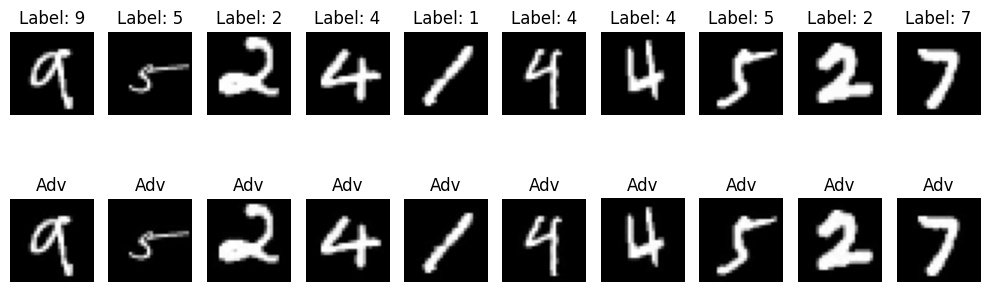

In [7]:
plt.figure(figsize=(10, 4))
for i, (orig, adv, label) in enumerate(adversarial_examples):
    plt.subplot(2, 10, i+1)
    plt.imshow(orig.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

    plt.subplot(2, 10, i+11)
    plt.imshow(adv.squeeze(), cmap='gray')
    plt.title("Adv")
    plt.axis('off')
plt.tight_layout()
plt.show()

**Entraînement sur les exemples adversaires**

In [8]:
x_adv_train = []
y_adv_train = []

for i in range(1000):
    image = x_train[i]
    label = y_train[i]
    perturbation = create_adversarial_pattern(model, image, label)
    adversarial_img = image + epsilon * perturbation[0]
    adversarial_img = tf.clip_by_value(adversarial_img, 0.0, 1.0)
    x_adv_train.append(adversarial_img)
    y_adv_train.append(label)

x_adv_train = np.array(x_adv_train)
y_adv_train = np.array(y_adv_train)

x_combined = np.concatenate([x_train[:1000], x_adv_train])
y_combined = np.concatenate([y_train[:1000], y_adv_train])

model_adv = create_model()
model_adv.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model_adv.fit(x_combined, y_combined, epochs=5, validation_split=0.1)


Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5914 - loss: 1.4057 - val_accuracy: 0.8550 - val_loss: 0.4008
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8993 - loss: 0.3286 - val_accuracy: 0.9300 - val_loss: 0.2416
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9659 - loss: 0.1469 - val_accuracy: 0.9400 - val_loss: 0.2070
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9767 - loss: 0.1111 - val_accuracy: 0.9750 - val_loss: 0.0809
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0578 - val_accuracy: 1.0000 - val_loss: 0.0337


**Evaluation sur images adversaires**

In [9]:
x_test_adv = []
for i in range(len(x_test)):
    pert = create_adversarial_pattern(model_adv, x_test[i], y_test[i])
    x_test_adv.append(tf.clip_by_value(x_test[i] + epsilon * pert[0], 0.0, 1.0))
x_test_adv = np.array(x_test_adv)

adv_loss, adv_acc = model_adv.evaluate(x_test_adv, y_test, verbose=2)
print("\nAdversarial test accuracy:", adv_acc)

157/157 - 0s - 1ms/step - accuracy: 0.8970 - loss: 0.3590

Adversarial test accuracy: 0.8970000147819519


# **Analyse et défense adversariale**

# - *FGSM* : attaque rapide qui perturbe les pixels selon le gradient de perte
# - *Adversarial Training* : consiste à inclure les données perturbées pendant l'entraînement

# *Accuracy propre* : 0.9847  
# *Accuracy avec attaques* : 0.4354  
# 
# *Commentaires* : 
# - La robustesse augmente contrairement à la première version, car on a diminué la valeur d'epsilone pour avoir moins de perturbation
# - Mais l'entraînement est plus long
